# Liver cirrhosis prediction using XGboost and Stratified K-fold⚕

By Arjun Bhaybhang

Linkedin : https://www.linkedin.com/in/arjun-bhaybhang/

Email    : bhaybhang.arjun@gmail.com

Dont forget to upvote :)

# Summary : 
Liver cirrhosis is a widespread problem especially in North America due to high intake of alcohol. In this project, we will predict liver cirrhosis in a patient based on certain lifestyle and health conditions of a patient.

Cirrhosis is a late stage of scarring (fibrosis) of the liver caused by many forms of liver diseases and conditions, such as hepatitis and chronic alcoholism. 

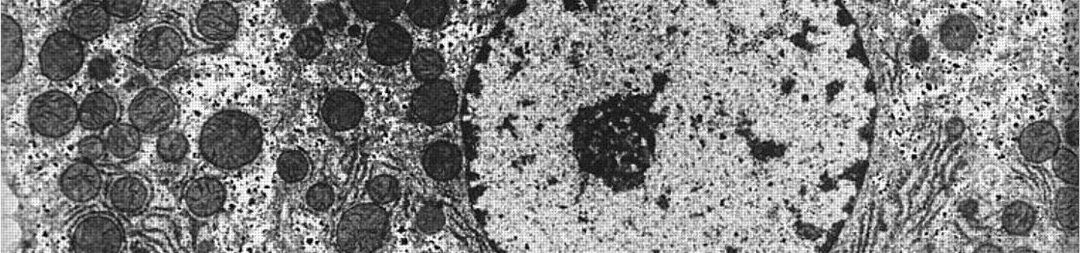

# About Data 🗄
The data contains the information collected from the Mayo Clinic trial in primary biliary cirrhosis (PBC) of the liver conducted between 1974 and 1984. A description of the clinical background for the trial and the covariates recorded here is in Chapter 0, especially Section 0.2 of Fleming and Harrington, Counting
Processes and Survival Analysis, Wiley, 1991. A more extended discussion can be found in Dickson, et al., Hepatology 10:1-7 (1989) and in Markus, et al., N Eng J of Med 320:1709-13 (1989).

A total of 424 PBC patients, referred to Mayo Clinic during that ten-year interval, met eligibility criteria for the randomized placebo-controlled trial of the drug D-penicillamine. The first 312 cases in the dataset participated in the randomized trial and contain largely complete data. The additional 112 cases did not participate in the clinical trial but consented to have basic measurements recorded and to be followed for survival. Six of those cases were lost to follow-up shortly after diagnosis, so the data here are on an additional 106 cases as well as the 312 randomized participants.

The dataset consists of following columns :
1. ID: unique identifier
2. N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
3. Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4. Drug: type of drug D-penicillamine or placebo
5. Age: age in [days]
6. Sex: M (male) or F (female)
7. Ascites: presence of ascites N (No) or Y (Yes)
8. Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
9. Spiders: presence of spiders N (No) or Y (Yes)
10. Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
11. Bilirubin: serum bilirubin in [mg/dl]
12. Cholesterol: serum cholesterol in [mg/dl]
13. Albumin: albumin in [gm/dl]
14. Copper: urine copper in [ug/day]
15. Alk_Phos: alkaline phosphatase in [U/liter]
16. SGOT: SGOT in [U/ml]
17. Triglycerides: triglicerides in [mg/dl]
18. Platelets: platelets per cubic [ml/1000]
19. Prothrombin: prothrombin time in seconds [s]
20. Stage: histologic stage of disease (1, 2, 3, or 4)

# Imports 

In [ ]:
# %load_ext google.colab.data_table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Lets Load the data and have a quick look.

In [ ]:
#@title Default title text
df = pd.read_csv('../input/cirrhosis-prediction-dataset/cirrhosis.csv', index_col='ID')
df.head()

In [ ]:
df.info()

This data set has about 19 features. These features are related to the patient’s details like age, sex, etc. and patient’s blood tests like prothrombin, triglycerides, platelets levels, etc. All these factors help in understanding a patient’s chances of liver cirrhosis.

we have some NA values in our data, lets look at some statistical summary of numerical columns in out dataset.

In [ ]:
df.describe()

## We have some missing values in our data, lets see how many and in which columns.

In [ ]:
df.isna().sum()

# Handling Missing Values
This is a problem, we could just get rid of all examples with NA values, but in this case our case of small dataset we cannot afford that. 

We will impute the missing entries with some statistical calculations.

# We have two different types of data
1. Numerical data  ( Age, Cholesterol, Platelets.. etc)
2. Categorical Data ( Drug, Sex, Spiders..etc)

We will have to use different imputation for each type

1. For the numerical type we can use mean or median. In this case we will go with median to avoid skewing in the presence of outliers
2. For Categorical type we will impute the most frequent class.

In [ ]:
# For Numerical Type
df.select_dtypes(include=(['int64', 'float64'])).isna().sum()

In [ ]:
df.select_dtypes(include=(['int64', 'float64'])).isna().sum()
df_num_col = df.select_dtypes(include=(['int64', 'float64'])).columns
for c in df_num_col:
    df[c].fillna(df[c].median(), inplace=True)

df.select_dtypes(include=(['int64', 'float64'])).isna().sum()

In [ ]:
# For Categorical type
df.select_dtypes(include=('object')).isna().sum()

In [ ]:
df_cat_col = df.select_dtypes(include=('object')).columns
for c in df_cat_col:
    df[c].fillna(df[c].mode().values[0], inplace=True)
    
df.select_dtypes(include=('object')).isna().sum()

Alright now our dataset contains no missing values 😌

# Exploratory Data Analysys
## Lets dive into the data and visualize it, this often revels interesting patterns.
First lets take a look at how many examples per calss do we have in our dataset.

In [ ]:
df['Stage'].value_counts()

In [ ]:
plt.figure(figsize=(21,5))
sns.countplot(y=df['Stage'], palette="flare", alpha=0.8, )
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Number of Example Per Class')

As we can observe we have class imbalances in our dataset i.e some classes have more examples than other. This could make it difficult for our model to train and achieve desired score. No worries, we can fix that later.

# Setting up Target and Features

### For this demonstration we will keep things simple by predicting one of the two classes  i.e (Cirrhosis and No Cirrhois). I have another project that predicts the stage of the disease, converting this problem into a multicalss classification.

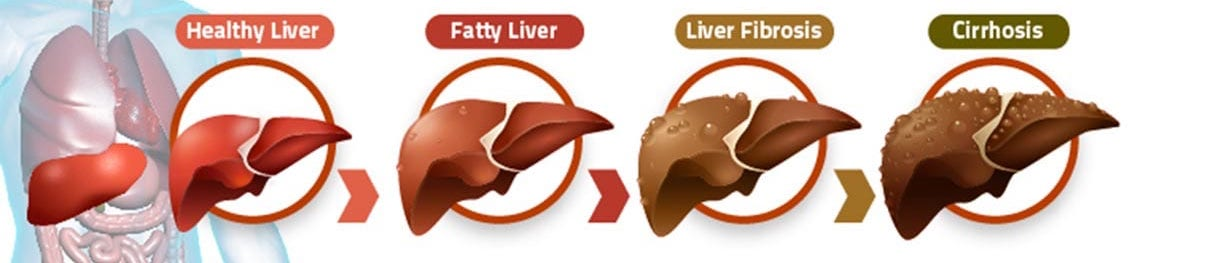

In [ ]:
# Converting Target categories into intigers 1 for Cirrhosis, 0 otherwise
df['Stage'] = np.where(df['Stage'] == 4,1,0)

## Lets observe some Features with their relation with the disease

In [ ]:
plt.figure(figsize=(21.2,10))

plt.subplot(2,3,1)
sns.countplot(x=df['Stage'], hue=df['Sex'], palette='Blues', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Disease Stage Across Gender')

plt.subplot(2,3,2)
sns.countplot(x=df['Stage'], hue=df['Ascites'], palette='Purples', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Ascites proportion across Stages')

plt.subplot(2,3,3)
sns.countplot(x=df['Stage'], hue=df['Drug'], palette='Blues', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Medications prescribed across Stages');

plt.subplot(2,3,4)
sns.countplot(x=df['Stage'], hue=df['Hepatomegaly'], palette='Purples', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Hepatomegaly');

plt.subplot(2,3,5)
sns.countplot(x=df['Stage'], hue=df['Spiders'], palette='Blues', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Presence of Spiders across stages');

plt.subplot(2,3,6)
sns.countplot(x=df['Stage'], hue=df['Edema'], palette='Purples', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Edema');

There are some interesting insights if we observe closely. Take the case at Ascites, we observe that the rist of disease is higher with increase in Ascites. also presence of spiders has a positive relation with disease risk.

In [ ]:
#@title Distribution Polts
plt.figure(figsize=(20.6,15))

plt.subplot(3,3,1)
sns.kdeplot(df['Cholesterol'], hue=df['Stage'], fill=True, palette='Purples')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Cholesterol Distribution in stages');

plt.subplot(3,3,2)
sns.kdeplot(df['Bilirubin'], hue=df['Stage'], fill=True, palette='Blues', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Bilirubin');

plt.subplot(3,3,3)
sns.kdeplot(df['Tryglicerides'], hue=df['Stage'], fill=True, palette='Purples', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Tryglicerides');

plt.subplot(3,3,4)
sns.kdeplot(df['Age'], hue=df['Stage'], fill=True, palette='Blues', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Age Distribution in stages');

plt.subplot(3,3,5)
sns.kdeplot(df['Prothrombin'], hue=df['Stage'], fill=True, palette='Purples', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Prothrombin');

plt.subplot(3,3,6)
sns.kdeplot(df['Copper'], hue=df['Stage'], fill=True, palette='Blues', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Copper');

plt.subplot(3,3,7)
sns.kdeplot(df['Platelets'], hue=df['Stage'], fill=True, palette='Purples')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Platelets in stages');

plt.subplot(3,3,8)
sns.kdeplot(df['Albumin'], hue=df['Stage'], fill=True, palette='Blues', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Albumin');

plt.subplot(3,3,9)
sns.kdeplot(df['SGOT'], hue=df['Stage'], fill=True, palette='Purples', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('SGOT');

### Looking at the feature distribution we can observe that in features such as Age, Prothrombin, Copper the risk of the disease increase with increase in feature value, thus having a positive co-relation on with the disease probability. Lets fit a regression line to check.

In [ ]:
#@title Regression Plots of Positive Correlated Features.
plt.figure(figsize=(21,12))

plt.subplot(3,1,1)
sns.regplot(x=df['Age'], y=df['Stage'], scatter=False, logistic=True, color='royalblue')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Probability');
plt.setp(plt.title('Cirrhosis Probability with increasing Age(in days)'), color='royalblue') ;

plt.subplot(3,1,2)
sns.regplot(x=df['Prothrombin'], y=df['Stage'], scatter=False, logistic=True, color='orchid');
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Probability');
plt.setp(plt.title('Cirrhosis Probability with increasing Prothrombin Content'), color='darkmagenta');

plt.subplot(3,1,3)
sns.regplot(x=df['Copper'], y=df['Stage'], scatter=False, logistic=True, color='royalblue')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Probability');
plt.setp(plt.title('Cirrhosis Probability with increasing Copper Accumulation'), color='royalblue') ;

Looks like the data checks with our intuition. These parameters indeed increase the risk of the disease.

### We can also observe some features such as Platelets, Albumin, Cholesterol where the probability of disease decrease with increase in feature value. Lets tally that with some more regression plots.

In [ ]:
#@title Regression Plots of negatively correlated Features.
plt.figure(figsize=(21,12))

plt.subplot(3,1,1)
sns.regplot(x=df['Platelets'], y=df['Stage'], scatter=False, logistic=True, color='orchid')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Probability');
plt.setp(plt.title('Cirrhosis Probability with Platelets'), color='darkmagenta');

plt.subplot(3,1,2)
sns.regplot(x=df['Albumin'], y=df['Stage'], scatter=False, logistic=True, color='royalblue');
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Probability');
plt.setp(plt.title('Cirrhosis Probability with Albumin Content'), color='royalblue');

plt.subplot(3,1,3)
sns.regplot(x=df['Cholesterol'], y=df['Stage'], scatter=False, logistic=True, color='orchid')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Probability');
plt.setp(plt.title('Cirrhosis Probability Cholesterol'), color='darkmagenta') ;

Platelets, Albumin checks with our logic the findings about Cholesterol seems interesting! Looks like people with high Cholesterol have lower risk of Cirrhosis, this might not sound correct but our data certainly shows so. 

This should help our model predict the target. We will be looking at what features contribute the most in later part of the project.

# Preprocessing data

In [ ]:
# replacing catagorical data with intigers.
df['Sex'] = df['Sex'].replace({'M':0, 'F':1})                                # Male : 0 , Female :1
df['Ascites'] = df['Ascites'].replace({'N':0, 'Y':1})                        # N : 0, Y : 1   
df['Drug'] = df['Drug'].replace({'D-penicillamine':0, 'Placebo':1})          # D-penicillamine : 0, Placebo : 1   
df['Hepatomegaly'] = df['Hepatomegaly'].replace({'N':0, 'Y':1})              # N : 0, Y : 1
df['Spiders'] = df['Spiders'].replace({'N':0, 'Y':1})                        # N : 0, Y : 1
df['Edema'] = df['Edema'].replace({'N':0, 'Y':1, 'S':-1})                    # N : 0, Y : 1, S : -1
df['Status'] = df['Status'].replace({'C':0, 'CL':1, 'D':-1})                 # 'C':0, 'CL':1, 'D':-1

## We will not be using 'Status' and 'N_days' as our features since this will cause data Leakage.

In [ ]:
# Setting up Features and Target
X = df.drop(['Status', 'N_Days', 'Stage'], axis=1)
y = df.pop('Stage')

### Earlier while examining the distribution of target in the data, we found that the data is unevenly distributed, that is there are more examples of a certain class than other. 

###To tackel this imbalance we will use **Stratified k-Fold** Cross Validation.

# Model Selection. 
lets first try out a quick Logestic regression classifier and see how it performs.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

log_model = LogisticRegression(max_iter=5000, solver='saga')
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

acc=[]
def training(train, test, fold_no):
  X_train = train
  y_train = y.iloc[train_index]
  X_test = test
  y_test = y.iloc[test_index]
  log_model.fit(X_train, y_train)
  score = log_model.score(X_test,y_test)
  acc.append(score)
  print('For Fold {} the accuracy is {}'.format(str(fold_no),score))

fold_no = 1
for train_index,test_index in skf.split(X, y):
  train = X.iloc[train_index,:]
  test = X.iloc[test_index,:]
  training(train, test, fold_no)
  fold_no += 1
print()
print('Logestic Regression Mean Accuracy = ', np.mean(acc))

In [ ]:
from sklearn.metrics import classification_report
log_model_predict = log_model.predict(test)
log_model_predict_proba = log_model.predict_proba(test)

print(classification_report(y.iloc[test_index], log_model_predict))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y.iloc[test_index], log_model_predict_proba[:,1])
roc_auc = auc(fpr, tpr)

print('AUC : ', roc_auc_score(y.iloc[test_index], log_model_predict_proba[:,1]))

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(21,6))

plt.subplot(1,2,1)
plt.title('Receiver Operating Characteristic for Logestic Regression')
sns.lineplot(x=fpr, y=tpr, label = 'AUC = %0.2f' % roc_auc, palette='purple', linewidth=3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tick_params(left=False, bottom=False)
sns.despine(top=True, bottom=True, left=True)

# calculate precision-recall curve
from sklearn.metrics import precision_recall_curve, f1_score
precision, recall, thresholds = precision_recall_curve(y.iloc[test_index], log_model_predict_proba[:,1])

plt.subplot(1,2,2)
plt.plot(precision, recall, linewidth=3, color='orchid')
sns.despine(top=True, bottom=True, left=True)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve for Logestic regression');

### After tuning several parameters the logestic regressor model was best able achieve about 70% accuracy and with 0.65 AUC. We might get better scores with some more sophisticated model.

## Lets try Gradient Boosted Classifier from **XGboost**.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
model = XGBClassifier(learning_rate=0.75, max_depth=3, random_state=1, gamma=0, eval_metric='error') # tried learning rate values between range [0.01 - 10] & depth [2-8]

acc=[]
def training(train, test, fold_no):
  X_train = train
  y_train = y.iloc[train_index]
  X_test = test
  y_test = y.iloc[test_index]
  model.fit(X_train, y_train)
  score = model.score(X_test,y_test)
  acc.append(score)
  print('For Fold {} the accuracy is {}'.format(str(fold_no),score))

fold_no = 1
for train_index,test_index in skf.split(X, y):
  train = X.iloc[train_index,:]
  test = X.iloc[test_index,:]
  training(train, test, fold_no)
  fold_no += 1
print()
print('XGboost model Mean Accuracy = ', np.mean(acc))

In [ ]:
from sklearn.metrics import classification_report
XGB_model_predict = model.predict(test)
XGB_model_predict_proba = model.predict_proba(test)

print(classification_report(y.iloc[test_index], XGB_model_predict))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y.iloc[test_index], XGB_model_predict_proba[:,1])
roc_auc = auc(fpr, tpr)

print('AUC : ', roc_auc_score(y.iloc[test_index], XGB_model_predict_proba[:,1]))

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(21,6))

plt.subplot(1,2,1)
plt.title('Receiver Operating Characteristic')
sns.lineplot(x=fpr, y=tpr, label = 'AUC = %0.2f' % roc_auc, palette='purple', linewidth=3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tick_params(left=False, bottom=False)
sns.despine(top=True, bottom=True, left=True)

# calculate precision-recall curve
from sklearn.metrics import precision_recall_curve, f1_score
precision, recall, thresholds = precision_recall_curve(y.iloc[test_index], XGB_model_predict_proba[:,1])

plt.subplot(1,2,2)
plt.plot(precision, recall, linewidth=3, color='orchid')
sns.despine(top=True, bottom=True, left=True)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve');

## Thats a significant improvement over the logestic regression. We now have about **0.74 AUC with about 74% accuracy**. This is pretty remarkable considering we only have about **400 training examples!**

# Methods to further improve scores
1. More Training Data : with just about 400 training examples we were able to achieve pretty significant scores, however the scores can massively improve by training our model with a bigger dataset.

2. A CNN might better fit by capturing finer details of the data. I have tried that in my other project where I convert this into a multiclass classification predicting the stage of the disease.


# Model Explaination With SHAP

In [ ]:
import shap
from sklearn.ensemble import RandomForestClassifier         # using random forest to explain for ease
rfc = RandomForestClassifier(max_features=2,n_estimators=100,bootstrap=True)

rfc.fit(train, y.iloc[train_index])

explainer = shap.TreeExplainer(rfc)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(test)
shap.summary_plot(shap_values, train, plot_size=(20,11), alpha=0.2, plot_type='bar')

### The abve plot shows what features contribute highest towards predicting a positive class. Prothrombin, Albumin, Hepatomegaly are highly corelated with the disease prediction and features like Gender, Drug, Ascites have the least corelation

Do checkout my other project which is more extensive version of this using Neural Network that is able to predict the stage of the liver!

Thank you for reading 🙏